In [1]:
from matplotlib.patches import Rectangle
import glob
from lxml import etree
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 加载图像
img = tf.io.read_file(
    '../data/location/images1/images/Abyssinian_1.jpg')
# 进行编码解析
img = tf.image.decode_jpeg(img)

In [3]:
img.shape

TensorShape([400, 600, 3])

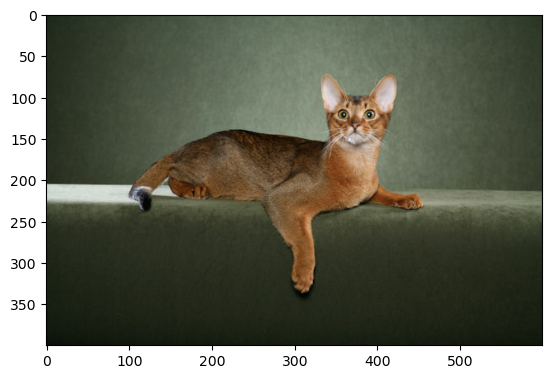

In [4]:
plt.imshow(img)

In [6]:
xml = open(
    '../data/location/annotations1/annotations/xmls/Abyssinian_1.xml').read()

In [7]:
sel = etree.HTML(xml)

In [8]:
# 获取xml数据
width = int(sel.xpath('//size/width/text()')[0])
height = int(sel.xpath('//size/height/text()')[0])
xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
ymax = int(sel.xpath('//bndbox/ymax/text()')[0])

In [9]:
width, height, xmin, xmax, ymin, ymax

(600, 400, 333, 425, 72, 158)

In [ ]:
# 绘制矩形框
plt.imshow(img)
rect = Rectangle((xmin, ymin), (xmax-xmin),
                 (ymax-ymin), fill=False, color='red')
ax = plt.gca()
ax.axes.add_patch(rect)

In [ ]:
# 注意，图像加载时是按照0-255的大小，需要通过归一化将数据限定在0-1
img = tf.image.resize(img, [224, 224])
img = img/255.0
# plt.imshow(img)

In [ ]:
# 对图像框做比例缩放
xmin = (xmin/width)*224
xmax = (xmax/width)*224
ymin = (ymin/height)*224
ymax = (ymax/height)*224

In [ ]:
# 绘制矩形框
plt.imshow(img)
rect = Rectangle((xmin, ymin), (xmax-xmin),
                 (ymax-ymin), fill=False, color='red')
ax = plt.gca()
ax.axes.add_patch(rect)

---

## 创建输入管道

In [ ]:
from matplotlib.patches import Rectangle
import glob
from lxml import etree
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
images = glob.glob('/home/jhr/Documents/data/location/images1/images/*.jpg')

In [ ]:
images[:5], len(images)

In [ ]:
xmls = glob.glob(
    '/home/jhr/Documents/data/location/annotations1/annotations/xmls/*.xml')

In [ ]:
# 对xml文件进行从a-z的排序
xmls.sort(key=lambda x: x.split('/')[-1].split('.xml')[0])

In [ ]:
names = [x.split('/')[-1].split('.xml')[0] for x in xmls]

In [ ]:
len(names), names[:5]

In [ ]:
# 测试数据集合
imgs_train = [img for img in images if (
    img.split('/')[-1].split('.jpg')[0]) in names]

In [ ]:
# 进行a-z排序
imgs_train.sort(key=lambda x: x.split('/')[-1].split('.jpg')[0])

In [ ]:
len(imgs_train), imgs_train[:5]

In [ ]:
# 测试数据集
img_test = [img for img in images if (
    img.split('/')[-1].split('.jpg')[0]) not in names]

In [ ]:
len(img_test)

In [ ]:
def to_path(path):
    xml = open('{}'.format(path)).read()
    sel = etree.HTML(xml)

    # 获取xml数据
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    # 输出比例值
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [ ]:
# xmin,ymin,xmax,ymax
labels = [to_path(path) for path in xmls]

In [ ]:
# 将列表数据分成四个单独数据
out1, out2, out3, out4 = list(zip(*labels))

In [ ]:
# 转化为numpy数据类型
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)

In [ ]:
label_dataset = tf.data.Dataset.from_tensor_slices((out1, out2, out3, out4))

In [ ]:
label_dataset

In [ ]:
@tf.function
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img/127.5 - 1
    return img

In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_dataset = image_dataset.map(load_image,
num_parallel_calls=AUTOTUNE)

In [ ]:
image_dataset

In [ ]:
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

**单机多卡训练**

In [ ]:
batch_size_per_replica=64#单卡batch数量
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: %d' % strategy.num_replicas_in_sync)  # 輸出設備數量
batch_size=batch_size_per_replica*strategy.num_replicas_in_sync #输出总batch

**创建测试数据集以及训练数据集**

In [ ]:
test_count = int(len(imgs_train)*0.2)
train_count = len(imgs_train)-test_count
test_count, train_count

dataset_train = dataset.skip(train_count)
dataset_test = dataset.skip(test_count)

# batch_size=64

dataset_train = dataset_train.repeat().shuffle(train_count).batch(batch_size)
dataset_test = dataset.repeat().batch(batch_size)

In [ ]:
# # 显示数据
# for img, label in dataset_train.take(3):
#     plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
#     out1, out2, out3, out4 = label
#     xmin, ymin, xmax, ymax = out1[0].numpy(
#     )*224, out2[0].numpy()*224, out3[0].numpy()*224, out4[0].numpy()*224
#     rect = Rectangle((xmin, ymin), (xmax-xmin),
#                      (ymax-ymin), fill=False, color='red')
#     ax = plt.gca()
#     ax.axes.add_patch(rect)
#     plt.show()

### 创建模型

**单卡训练**

In [ ]:
# #加载预训练模型
# xception = tf.keras.applications.Xception(weights='imagenet',
#                                           include_top=False,
#                                           input_shape=(224, 224, 3))
# # xception.trainabler = False

# inputs = tf.keras.layers.Input(shape=(224, 224, 3))
# x = xception(inputs)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全连接层
# x = tf.keras.layers.Dense(2048, activation='relu')(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)

# out1 = tf.keras.layers.Dense(1)(x)
# out2 = tf.keras.layers.Dense(1)(x)
# out3 = tf.keras.layers.Dense(1)(x)
# out4 = tf.keras.layers.Dense(1)(x)

# #创建模型
# prediction = [out1, out2, out3, out4]
# model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

# #编译模型
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss='mse',
#               metrics=['mae'])

**多卡训练**

In [ ]:
with strategy.scope():
  xception = tf.keras.applications.Xception(weights='imagenet',
                                          include_top=False,
                                          input_shape=(224, 224, 3))
  xception.trainabler = False

  inputs = tf.keras.layers.Input(shape=(224, 224, 3))
  x = xception(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全连接层
  x = tf.keras.layers.Dense(2048, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)

  out1 = tf.keras.layers.Dense(1)(x)
  out2 = tf.keras.layers.Dense(1)(x)
  out3 = tf.keras.layers.Dense(1)(x)
  out4 = tf.keras.layers.Dense(1)(x)

  prediction = [out1, out2, out3, out4]
  model = tf.keras.models.Model(inputs=inputs, outputs=prediction)
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])

In [ ]:
# model.summary()

In [ ]:
EPOCHS = 50

In [ ]:
history = model.fit(dataset_train,
                    epochs=EPOCHS,
                    steps_per_epoch=train_count//batch_size,
                    validation_data=dataset_test,
                    validation_steps=test_count//batch_size
                    )

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.epoch, history.history.get('loss'), label='loss', color='b')
plt.plot(history.epoch, history.history.get(
    'val_loss'), label='val_loss', color='r')

In [ ]:
# 注意，模型保存在训练服务器上
model.save('location_v1.h5')

### 加载模型测试

In [ ]:
# 在测试服务器上加载模型
new_model = tf.keras.models.load_model('./location_v1.h5')

In [ ]:
# 注意，dataset是一个batch，因此out输出的是一个batch的数据
for img, _ in dataset_test.take(1):
    out1, out2, out3, out4 = new_model.predict(img)
    for i in range(9):
        plt.figure(figsize=(8,24))
        plt.subplot(9,1,1+i)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin, ymin, xmax, ymax = out1[i] * \
            224, out2[i]*224, out3[i]*224, out4[i]*224

        rect = Rectangle((xmin, ymin), (xmax-xmin),
                         (ymax-ymin), fill=False, color='red')

        ax = plt.gca()
        ax.axes.add_patch(rect)
        plt.show()

In [ ]:
# tf.saved_model.save(model,"../")